In [4]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import time

import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d
print(theano.config.device)
print(theano.config.floatX)


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

/home/ec2-user/anaconda3/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:556: UserWarning: Theano flag device=gpu* (old gpu back-end) only support floatX=float32. You have floatX=float64. Use the new gpu back-end with device=cuda* for that value of floatX.
  warnings.warn(msg)
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)


gpu
float64


In [5]:
TRAIN = '~/data/facial_keypoints/training.csv'
TEST = '~/data/facial_keypoints/test.csv'

def load_data(path):
    df = read_csv(os.path.expanduser(path))  # load pandas dataframe
    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    df = df.dropna()  # drop all rows that have missing values in them
    return df

data = load_data(TRAIN)
X = np.vstack(data['Image'].values) / 255.  # scale pixel values to [0, 1]
y = data[data.columns[:-1]].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]

X = X.astype(theano.config.floatX)
y = y.astype(theano.config.floatX)

X, y = shuffle(X, y, random_state=42)  # shuffle train data
num_train = len(X)
train_data, train_labels = X[int(num_train/5):],y[int(num_train/5):]
dev_data, dev_labels = X[:int(num_train/5)],y[:int(num_train/5)]

train_data = train_data.astype(theano.config.floatX)
train_labels = train_labels.astype(theano.config.floatX)
dev_data = dev_data.astype(theano.config.floatX)
dev_labels = dev_labels.astype(theano.config.floatX)



In [6]:
train_data.shape
num_train

2140

In [8]:
## (1) Parameters
miniBatchSize = 10 #Batch size for the gradient descent
N = miniBatchSize #Number of samples to compute the mean squared error
numClasses = train_labels[1].size #Number of outputs we require
numFeatures = train_data[1].size #Number of inputs
numHiddenNodes = 300 #Number of nodes in the hidden layer



#Randomly initialized weights for our network
w_1 = theano.shared(np.asarray((np.random.randn(* (32, 1, 3, 3)) *.01)))
w_2 = theano.shared(np.asarray((np.random.randn(* (64, 32, 3, 3)) *.01)))
w_3 = theano.shared(np.asarray((np.random.randn(* (128, 64, 3, 3)) *.01)))
w_4 = theano.shared(np.asarray((np.random.randn(*(12*12*128, numHiddenNodes))*.01)))
w_5 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01)))
params = [w_1, w_2, w_3, w_4, w_5]

## (2) Model
X = T.tensor4()
Y = T.matrix()

train_data = train_data.reshape(-1,1,96,96)
dev_data = dev_data.reshape(-1,1,96,96)

srng = RandomStreams()
def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p=1 - p)
        X /= 1 - p
    return X


def model(X, w_1, w_2, w_3, w_4, w_5, p_1, p_2):
    l1 = dropout(pool_2d(T.maximum(conv2d(X, w_1, border_mode=(1,1)), 0.), (2, 2)), p_1)
    l2 = dropout(pool_2d(T.maximum(conv2d(l1, w_2, border_mode=(1,1)), 0.), (2, 2)), p_1)
    l3 = T.flatten(dropout(pool_2d(T.maximum(conv2d(l2, w_3, border_mode=(1,1)), 0.), (2, 2)), p_1), outdim=2)
    return T.dot(dropout(T.nnet.sigmoid(T.dot(dropout(l3, p_1), w_4)), p_2), w_5)

y_hat_train = model(X, w_1, w_2, w_3, w_4, w_5, 0.2, 0.3)
y_hat_predict = model(X, w_1, w_2, w_3, w_4, w_5, 0., 0.)

## (3) Cost...mean squared loss
cost = T.sum(T.pow(y_hat_train-Y,2))/(2*N)

## (4) Minimization.  Update rule changes to backpropagation.
alpha = 0.1 #the learning rate
learningRateSchedule = np.linspace(0.3, 0.0001, 100)

#we use theanos built-in gradient function and use this in our backprop step
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha])
    return updates

update = backprop(cost, params)

#The training function which outputs the cost
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
y_pred = y_hat_predict

#The prediction function
predict = theano.function(inputs=[X], outputs=y_pred, allow_input_downcast=True)

#We use this to determine the validation error which is the Mean squared error
def get_validation_error(pred):
    return np.sum((pred-dev_labels)**2)/(2*dev_data.shape[0])

#We finally define the gradient descent function we use to train the model
baseline_1_loss=[]
baseline_1_validation=[]
baseline_1_epochs = []
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    totalTime = 0.0
    print("Epoch      Cost        RMSE         Execution Time(secs)")
    print("-----      ----        -----        --------------------")
    for i in range(epochs):
        start_time = time.time()
        
        for start, end in zip(range(0, len(train_data), miniBatchSize), range(miniBatchSize, len(train_data), miniBatchSize)):
            cost = train(train_data[start:end], train_labels[start:end])
        trainTime = (time.time() - start_time)
        baseline_1_loss.append(cost)
        baseline_1_validation.append(get_validation_error(predict(dev_data)))
        baseline_1_epochs.append(i+1)
        print("{0:<3}       {1:<0.5f}      {2:<2.3f}            {3:<1.3f}".format(i+1,cost*1.0,np.sqrt(cost) * 48,trainTime))
        totalTime = totalTime+trainTime
    print("Total Training time: {0} secs".format(totalTime))    


/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `ws == stride and pad == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use cuDNN. When using ignore_border=False and not using cuDNN, the only GPU combination supported is when `w

In [9]:
## 3 conv layers 2 nn layers
## p1 = 0.2, p2 = 0.3
gradientDescentStochastic(50)

Epoch      Cost        RMSE         Execution Time(secs)
-----      ----        -----        --------------------
1         0.70537      40.314            77.322
2         0.28647      25.691            76.318
3         0.26483      24.701            80.992
4         0.68091      39.608            80.934
5         0.45911      32.524            81.192
6         0.68367      39.689            81.759
7         0.63843      38.353            81.011
8         0.31530      26.953            81.292
9         0.28517      25.633            81.042
10        0.35270      28.507            81.381
11        0.76860      42.082            81.310
12        0.80492      43.064            81.392
13        0.91101      45.814            81.394
14        0.35803      28.721            80.377
15        0.60005      37.182            80.994
16        0.53574      35.133            71.522
17        0.63411      38.223            48.619
18        0.33888      27.943            48.859
19        0.66759     

In [27]:
## p1 = 0.2, p2 = 0.5
gradientDescentStochastic(50)

Epoch      Cost        RMSE         Execution Time(secs)
-----      ----        -----        --------------------
1         0.15280      18.763            47.731
2         0.13161      17.414            39.098
3         0.13304      17.508            40.212
4         0.15913      19.148            40.502
5         0.13438      17.596            44.009
6         0.16154      19.292            38.178
7         0.10643      15.659            58.172
8         0.10111      15.263            58.501
9         0.09679      14.934            58.896
10        0.10338      15.433            58.429
11        0.10521      15.569            59.025
12        0.09434      14.743            56.194
13        0.12993      17.302            56.025
14        0.11258      16.105            56.047
15        0.11091      15.986            56.717
16        0.13676      17.751            56.253
17        0.13864      17.873            55.959
18        0.10788      15.766            56.467
19        0.13205     

KeyboardInterrupt: 

In [31]:
## p1, p2 = 0
gradientDescentStochastic(50)

Epoch      Cost        RMSE         Execution Time(secs)
-----      ----        -----        --------------------
1         0.14832      18.486            46.649
2         0.14213      18.096            46.646
3         0.11219      16.077            46.361
4         0.09574      14.852            46.952
5         0.09067      14.453            46.644
6         0.08437      13.943            46.197
7         0.08037      13.608            46.225
8         0.07828      13.429            46.302
9         0.07618      13.249            46.120
10        0.07415      13.070            46.344
11        0.07202      12.881            46.405
12        0.06989      12.690            46.676
13        0.06761      12.481            46.437
14        0.06497      12.235            46.255
15        0.06222      11.974            46.697
16        0.05940      11.699            46.390
17        0.05697      11.457            44.255
18        0.05479      11.236            44.377
19        0.05199     

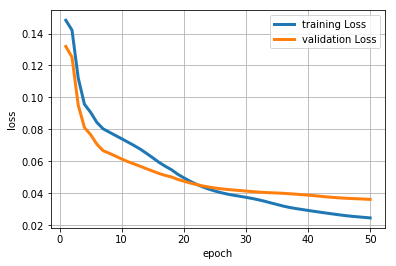

In [32]:
## p1, p2 = 0
plt.plot(baseline_1_epochs,baseline_1_loss, linewidth=3, label="training Loss")
plt.plot(baseline_1_epochs,baseline_1_validation, linewidth=3, label="validation Loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

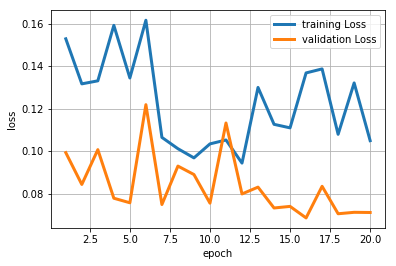

In [28]:
## p1 = 0.2, p2 = 0.5
plt.plot(baseline_1_epochs,baseline_1_loss, linewidth=3, label="training Loss")
plt.plot(baseline_1_epochs,baseline_1_validation, linewidth=3, label="validation Loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

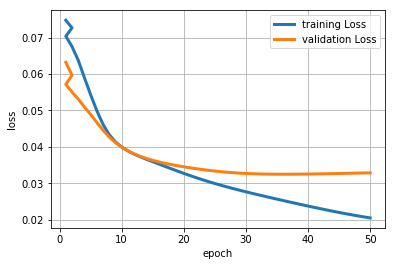

In [8]:
## non conv net
plt.plot(baseline_1_epochs,baseline_1_loss, linewidth=3, label="training Loss")
plt.plot(baseline_1_epochs,baseline_1_validation, linewidth=3, label="validation Loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()